# RobotFoodie - 
https://linear.app/closedloop/issue/CLO-34/feature-1-food-and-nutrient-tracking

ChatBot Flow

1. I describe my meal in natural language out loud 
1. transcribe to Text (via Whisper)
1. Generates the items and portion sizes
1. Asks follow-ups for clarification
1. Given a large description of a meal, back out the calories

In [50]:
import promptedgraphs
from pydantic import BaseModel, Field

from promptedgraphs.config import Config
from promptedgraphs.ideation import brainstorm
from promptedgraphs.vis import render_entities
from promptedgraphs.config import Config, load_config
from promptedgraphs.entity_recognition import extract_entities
from promptedgraphs.models import EntityReference
import spacy
from nltk.sentiment import SentimentIntensityAnalyzer
from typing import NamedTuple, Dict, List
import asyncio
import datetime

_ = load_config()

In [51]:
example = """today I had for breakfast, one decaf coffee, half a bagel and creem cheese 
that my kid didn't eat, a scoop of strawberry yogurt.  
"""

In [52]:
# Schema tags

food_logging_taxonomy = {
    'food-item': 'Something edible where we can likely find nutritional information',
    'portion-size': 'can be standard imperial or metric units like cups or ML, but could also be units like bowls, or the food count itself, like \'3 apples\'',
    'meal-name': 'typically breakfast, lunch, dinner, morning snack, second breakfast, etc...'
}

In [53]:
async def label_food_log(food_log_entry, model=None, temperature=0, include_reason=False):

    ents = []
    async for msg in extract_entities(
        name="food_log",
        description="For diet tracking app, exctract items relevant for logging one's food consumption",
        text=food_log_entry,
        temperature=temperature,
        labels=food_logging_taxonomy,
        model=model,
        config=Config(),
        include_reason=include_reason,
    ):
        ents.append(msg)
    return ents

In [54]:
ents_gpt3 = await label_food_log(example, model='gpt-3.5-turbo-1106', temperature=0)

render_entities(example, ents_gpt3)
display(ents_gpt3[-1])

Usage(model=gpt-3.5-turbo-1106, prompt_tokens=400, completion_tokens=79, duration=2.5387, cost=0.000558)

In [55]:
ents_gpt4 = await label_food_log(example, model='gpt-4', temperature=0)

render_entities(example, ents_gpt4)
display(ents_gpt4[-1])

Usage(model=gpt-4, prompt_tokens=393, completion_tokens=272, duration=15.6856, cost=0.028110)

In [56]:
ents_gpt4 = await label_food_log(example, model='gpt-4', temperature=0, include_reason=True)

render_entities(example, ents_gpt4)
display(ents_gpt4[-1])

Usage(model=gpt-4, prompt_tokens=420, completion_tokens=374, duration=20.0560, cost=0.035040)

## Using Extract_Data vs entity extraction


In [57]:
from pydantic import BaseModel, Field

from promptedgraphs.config import Config, load_config
from promptedgraphs.data_extraction import extract_data


class FoodLogEntry(BaseModel):
    """For diet tracking app, exctract items relevant for logging one's food consumption"""

    food_item: str = Field(
        title="Food Item",
        description="Something edible where we can likely find nutritional information",
        examples=[
            "cheese",
            "kellogs special K",
            "ice cream",
            "peanuts",
        ],
    )
    portion_size: str | None = Field(
        title="Portion Size",
        description="Can be standard imperial or metric units, could also be units like bowls, or the food count itself, like 'apples'",
        examples=['apples', 'cup', 'ml', 'tsp', 'bowl']
    )

class MealLog(BaseModel):
    """For diet tracking app, exctract items relevant for logging one's food consumption"""

    food_items: list[FoodLogEntry]
    meal_name: str | None = Field(
        title="Meal Name",
        description="a label for when the food was consumed",
        examples=['breakfast', 'lunch', 'dinner', 'morning snack', 'in car']
    )

# FoodLogEntry

In [58]:
def print_meal_logs(meal_logs: list[MealLog]):
    for meal in meal_logs:
        print(f"MEAL: {meal.meal_name}")
        for food in meal.food_items:
            print(f"\t* {food.food_item}\t({food.portion_size})")

In [59]:
load_config()

meal_logs = []
async for food_log in extract_data(
    text=example, output_type=MealLog, config=Config(), model='gpt-3.5-turbo-1106'
):
    meal_logs.append(food_log)
print_meal_logs(meal_logs)

MEAL: breakfast
	* decaf coffee	(1)
	* bagel with cream cheese	(half)
	* strawberry yogurt	(1 scoop)


In [60]:
extract_data?

In [61]:
# meal_logs = []
for i in range(5):
    async for food_log in extract_data(
        text=example, output_type=MealLog, config=Config(), model='gpt-4', temperature=0.2
    ):
        meal_logs.append(food_log)

print_meal_logs(meal_logs)

MEAL: breakfast
	* decaf coffee	(1)
	* bagel with cream cheese	(half)
	* strawberry yogurt	(1 scoop)
MEAL: breakfast
	* decaf coffee	(one)
	* half a bagel	(half)
	* creem cheese	(None)
	* strawberry yogurt	(a scoop)
MEAL: breakfast
	* decaf coffee	(one)
	* half a bagel	(half)
	* creem cheese	(None)
	* strawberry yogurt	(a scoop)
MEAL: breakfast
	* decaf coffee	(one)
	* half a bagel	(half)
	* creem cheese	(None)
	* strawberry yogurt	(a scoop)
MEAL: breakfast
	* decaf coffee	(one)
	* half a bagel	(half)
	* cream cheese	(None)
	* strawberry yogurt	(a scoop)
MEAL: breakfast
	* decaf coffee	(one)
	* half a bagel and cream cheese	(half)
	* strawberry yogurt	(a scoop)


In [62]:
parsed_log = """MEAL: breakfast
	* decaf coffee	(one)
	* half a bagel and cream cheese	(half)
	* strawberry yogurt	(a scoop)"""

# Connect Extracted Data to Real Data

Entity Linking Step
1. food_item -> food api
2. portion_size -> numerical units

###  API Data Source
https://fdc.nal.usda.gov/api-spec/fdc_api.html#/FDC/getFoodsSearch

In [63]:
# config = Config()
assert config.usda_api_key

In [64]:
import requests
def USDA_SearchFoods(query:str, **kwargs):
    """Search for foods using keywords. Results can be filtered by dataType and there are options for result page sizes or sorting.
    """
    url = "https://api.nal.usda.gov/fdc/v1/foods/search"
    params = {
        "query": query,
#         "dataType": "Foundation,SR Legacy",
        "pageSize": 50,
#         "sortBy": "description",
#         "sortOrder": "asc",
#         "brandOwner": "Kar Nut Products Company",
        "api_key": config.usda_api_key
    }
    params.update(kwargs)

    headers = {
        "accept": "application/json",
        
    }

    response = requests.get(url, params=params, headers=headers)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Request failed with status code: {response.status_code}")
        raise ValueError(response.text)


In [65]:
results = USDA_SearchFoods("bagel")
foods = results.get('foods', [])
foods = [f for f in foods if f['score'] >= 500]

display(foods[0:5])

[{'fdcId': 2343164,
  'description': 'Bagel',
  'commonNames': '',
  'additionalDescriptions': 'flavored bagel;water bagel;egg bagel;Bagel Thins;bialy',
  'dataType': 'Survey (FNDDS)',
  'foodCode': 51180010,
  'publishedDate': '2022-10-28',
  'foodCategory': 'Bagels and English muffins',
  'foodCategoryId': 2645999,
  'allHighlightFields': '<b>Includes</b>: flavored <em>bagel</em>;water <em>bagel</em>;egg <em>bagel</em>;<em>Bagel</em> Thins;bialy',
  'score': 1649.3352,
  'microbes': [],
  'foodNutrients': [{'nutrientId': 1003,
    'nutrientName': 'Protein',
    'nutrientNumber': '203',
    'unitName': 'G',
    'value': 10.6,
    'rank': 600,
    'indentLevel': 1,
    'foodNutrientId': 28696784},
   {'nutrientId': 1004,
    'nutrientName': 'Total lipid (fat)',
    'nutrientNumber': '204',
    'unitName': 'G',
    'value': 1.32,
    'rank': 800,
    'indentLevel': 1,
    'foodNutrientId': 28696785},
   {'nutrientId': 1005,
    'nutrientName': 'Carbohydrate, by difference',
    'nutrien

In [66]:
foods[0].keys()

dict_keys(['fdcId', 'description', 'commonNames', 'additionalDescriptions', 'dataType', 'foodCode', 'publishedDate', 'foodCategory', 'foodCategoryId', 'allHighlightFields', 'score', 'microbes', 'foodNutrients', 'finalFoodInputFoods', 'foodMeasures', 'foodAttributes', 'foodAttributeTypes', 'foodVersionIds'])

In [67]:
import pandas as pd

food_df = pd.DataFrame(foods)

<Axes: >

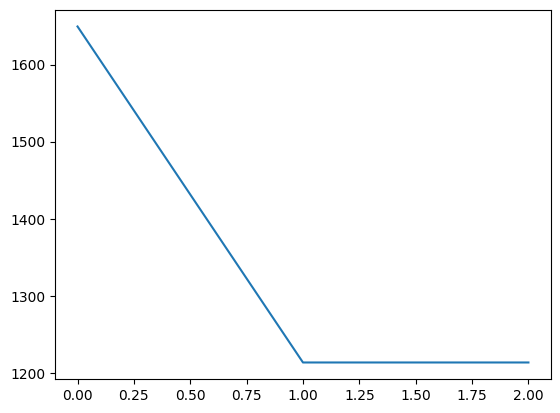

In [68]:
food_df.score.plot()

In [69]:
foods[0]

{'fdcId': 2343164,
 'description': 'Bagel',
 'commonNames': '',
 'additionalDescriptions': 'flavored bagel;water bagel;egg bagel;Bagel Thins;bialy',
 'dataType': 'Survey (FNDDS)',
 'foodCode': 51180010,
 'publishedDate': '2022-10-28',
 'foodCategory': 'Bagels and English muffins',
 'foodCategoryId': 2645999,
 'allHighlightFields': '<b>Includes</b>: flavored <em>bagel</em>;water <em>bagel</em>;egg <em>bagel</em>;<em>Bagel</em> Thins;bialy',
 'score': 1649.3352,
 'microbes': [],
 'foodNutrients': [{'nutrientId': 1003,
   'nutrientName': 'Protein',
   'nutrientNumber': '203',
   'unitName': 'G',
   'value': 10.6,
   'rank': 600,
   'indentLevel': 1,
   'foodNutrientId': 28696784},
  {'nutrientId': 1004,
   'nutrientName': 'Total lipid (fat)',
   'nutrientNumber': '204',
   'unitName': 'G',
   'value': 1.32,
   'rank': 800,
   'indentLevel': 1,
   'foodNutrientId': 28696785},
  {'nutrientId': 1005,
   'nutrientName': 'Carbohydrate, by difference',
   'nutrientNumber': '205',
   'unitName':

In [70]:
pd.DataFrame(foods[0]['foodNutrients']).tail(30)

,nutrientId,nutrientName,nutrientNumber,unitName,value,rank,indentLevel,foodNutrientId
35,1180,"Choline, total",421,MG,14.600,7220,1,28696819
36,1185,Vitamin K (phylloquinone),430,UG,0.200,8800,1,28696820
37,1186,Folic acid,431,UG,82.000,7000,0,28696821
38,1187,"Folate, food",432,UG,24.000,7100,1,28696822
39,1190,"Folate, DFE",435,UG,163.000,7200,1,28696823
40,1242,"Vitamin E, added",573,MG,0.000,7920,0,28696824
41,1246,"Vitamin B-12, added",578,UG,0.000,7340,0,28696825
42,1253,Cholesterol,601,MG,0.000,15700,1,28696826
43,1258,"Fatty acids, total saturated",606,G,0.360,9700,1,28696827
44,1259,SFA 4:0,607,G,0.000,9800,2,28696828


In [71]:
serving_size_columns = ['servingSizeUnit', 'servingSize','householdServingFullText']

In [72]:
food_df.dropna(subset=serving_size_columns)

,fdcId,description,commonNames,additionalDescriptions,dataType,foodCode,publishedDate,foodCategory,foodCategoryId,allHighlightFields,...,ingredients,marketCountry,modifiedDate,dataSource,packageWeight,servingSizeUnit,servingSize,householdServingFullText,shortDescription,tradeChannels
1,2283263,BAGEL,NaN,NaN,Branded,NaN,2022-05-23,Breads & Buns,NaN,,...,"WHITE AND BLACK SESAME SEEDS. ONION, GARLIC, P...",United States,2022-02-09,LI,5.5 oz/156 g,g,0.7,1/4 Tsp,,[NO_TRADE_CHANNEL]
2,684916,BAGEL,NaN,NaN,Branded,NaN,2019-12-06,Breads & Buns,NaN,,...,"WATER, POTATO STARCH, SOYA FLOUR, TAPIOCA STAR...",United States,2019-07-28,LI,NaN,g,50.0,1 BAGEL,NaN,[NO_TRADE_CHANNEL]


In [73]:
food_df.head(2).T

,0,1
fdcId,2343164,2283263
description,Bagel,BAGEL
commonNames,,NaN
additionalDescriptions,flavored bagel;water bagel;egg bagel;Bagel Thi...,NaN
dataType,Survey (FNDDS),Branded
foodCode,51180010.0,NaN
publishedDate,2022-10-28,2022-05-23
foodCategory,Bagels and English muffins,Breads & Buns
foodCategoryId,2645999.0,NaN
allHighlightFields,<b>Includes</b>: flavored <em>bagel</em>;water...,


In [74]:
current_meal = meal_logs[0]

current_meal

MealLog(food_items=[FoodLogEntry(food_item='decaf coffee', portion_size='1'), FoodLogEntry(food_item='bagel with cream cheese', portion_size='half'), FoodLogEntry(food_item='strawberry yogurt', portion_size='1 scoop')], meal_name='breakfast')

In [80]:
# for each food in a meal, search for it,
# get top result
foods_with_nutrients = []
for food_item in current_meal.food_items:
    matching_foods = USDA_SearchFoods(food_item.food_item)
    foods = matching_foods.get('foods',[]) 
    if len(foods) == 0:
        continue
    matching_food = foods[0]
    nutrients = matching_food['foodNutrients']
    serving_sizes = {k: matching_food.get(k) for k in serving_size_columns}
    foods_with_nutrients.append({
      "food_item": food_item.model_dump(),
        "nutrients": nutrients,
        "serving_sizes": serving_sizes,
        "scale_factor": None
    })
    

In [82]:
pd.DataFrame(foods_with_nutrients)

,food_item,nutrients,serving_sizes,scale_factor
0,food_item='decaf coffee' portion_size='1',"[{'nutrientId': 1003, 'nutrientName': 'Protein...","{'servingSizeUnit': 'g', 'servingSize': 2.0, '...",None
1,food_item='bagel with cream cheese' portion_si...,"[{'nutrientId': 1003, 'nutrientName': 'Protein...","{'servingSizeUnit': None, 'servingSize': None,...",None
2,food_item='strawberry yogurt' portion_size='1 ...,"[{'nutrientId': 1004, 'nutrientName': 'Total l...","{'servingSizeUnit': None, 'servingSize': None,...",None


In [86]:
foods_with_nutrients[1]['food_item']

FoodLogEntry(food_item='bagel with cream cheese', portion_size='half')

In [87]:
foods_with_nutrients[1]['serving_sizes']

{'servingSizeUnit': None,
 'servingSize': None,
 'householdServingFullText': None}

In [ ]:
# Next steps
Learn a mapping from portion size to 